# Animal Pose Estimation

In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision import transforms, utils
import torch
import torch.nn.functional as F
import warnings
import gdown
import os
import numpy as np
import cv2
from skimage import transform
import json
import random

import openpifpaf

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = torch.cuda.is_available()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\osour\OneDrive - epfl.ch\EPFL\MA2\CIVIL-459 Deep Learning For Autonomous Vehicles\CIVIL-459-Animal-Pose-Estimation\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\osour\AppData\Local\Temp\ipykernel_20780\2109439227.py", line 17, in <module>
    import openpifpaf
  File "c:\Users\osour\OneDrive - epfl.ch\EPFL\MA2\CIVIL-459 Deep Learning For Autonomous Vehicles\CIVIL-459-Animal-Pose-Estimation\.venv\lib\site-packages\openpifpaf\__init__.py", line 10, in <module>
    cpp_extension.register_ops()
  File "c:\Users\osour\OneDrive - epfl.ch\EPFL\MA2\CIVIL-459 Deep Learning For Autonomous Vehicles\CIVIL-459-Animal-Pose-Estimation\.venv\lib\site-packages\openpifpaf\cpp_extension.py", line 26, in register_ops
    torch.ops.load_library(ext_specs.origin)
  File "c:\Users\osour\OneDrive - epfl.ch\EPFL\MA2\CIVIL-459 Deep Learning For Autonomous

## 1. Dataset and Dataloader

In [16]:
!mkdir Dataset
!gdown "https://drive.google.com/drive/folders/1xxm6ZjfsDSmv6C9JvbgiGrmHktrUjV5x" -O Dataset --folder
!unzip Dataset/images.zip -d Dataset
#!mkdir -p Dataset\labels
#!mkdir -p Dataset\images\train Dataset\images\val Dataset\images\test Dataset\labels\train Dataset\labels\val Dataset\labels\test

A subdirectory or file Dataset already exists.


Processing file 1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF images.zip
Processing file 1bAidtvR3MttetncXz0mfr47vYy7Uf5hm keypoints.json
Building directory structure completed


Retrieving folder list
Retrieving folder list completed
Building directory structure
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF
From (redirected): https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF&confirm=t&uuid=416ef69a-b199-48e9-94ac-dd94a962e1a0
To: c:\Users\osour\OneDrive - epfl.ch\EPFL\MA2\CIVIL-459 Deep Learning For Autonomous Vehicles\CIVIL-459-Animal-Pose-Estimation\Dataset\images.zip

  0%|          | 0.00/368M [00:00<?, ?B/s]
  0%|          | 524k/368M [00:01<12:49, 477kB/s]
  0%|          | 1.05M/368M [00:01<07:58, 767kB/s]
  0%|          | 1.57M/368M [00:01<06:30, 938kB/s]
  1%|          | 2.10M/368M [00:02<06:35, 924kB/s]
  1%|          | 2.62M/368M [00:02<05:24, 1.13MB/s]
  1%|          | 3.15M/368M [00:03<05:15, 1.16MB/s]
  1%|          | 3.67M/368M [00:03<05:09, 1.18MB/s]
  1%|          | 4.19M/368M [00:04<05:05, 1.19MB/s]
  1%|▏         | 4.72M/368M [00:04<05:20, 1.13MB/s]
  1%|▏         | 5.24M/368M 

^C


A subdirectory or file -p already exists.
Error occurred while processing: -p.


In [19]:
# cow sheep horse cat dog
labels = {'dog':1, 'cat':2, 'sheep':3, 'horse':4, 'cow':5} 

face_color = (100, 200, 5)
limb_color = (0, 255, 0)
other_color = (200, 200, 50)
kp_color = (0, 0, 255)

segm_colors = [face_color] * 5 + [other_color] * 2 + [limb_color] * 4 + [other_color] * 4

def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))


def draw_keypoint(im, keypoints):
    '''
        order: 
        0-4 (face): left eye, right eye, nose, left earbase, right earbase
        5-16 (limbs):   L_F_elbow, R_F_elbow, L_B_elbow, R_B_elbow
                        L_F_knee, R_F_knee, L_B_knee, R_B_knee
                        L_F_paw, R_F_paw, L_B_paw, R_B_paw
        17-19 (others): throat, withers, tailbase
    '''
    segmts = [  (0,1), (0,2), (1,2), (0,3), (1,4),
                (2,17), (18,19),
                (5,9), (6,10), (7,11), (8,12),
                (9,13), (10,14), (11,15), (12,16)]


    for i in range(len(segmts)):
        segm = segmts[i]
        kp1 = keypoints[segm[0]]
        kp2 = keypoints[segm[1]]
        if kp1[2] == 0 or kp2[2] == 0:
            continue

        cv2.line(im, tuple(kp1[:2]), tuple(kp2[:2]), segm_colors[i], thickness=2)

    for kp in keypoints:
        if kp[2] == 0:
            continue
        cv2.circle(im, tuple(kp[:2]), radius=4, color=kp_color, thickness=-1)

    return im


def draw_bbox(im, xmin, ymin, xmax, ymax, color):
    cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color, thickness=2)
    return im 


def visualize_json():
    output_dir = "visualization_animalpose"
    os.makedirs(output_dir, exist_ok=True)
    anno_dict = json.load(open("keypoints.json"))
    image_map = anno_dict["images"]
    annotations = anno_dict["annotations"]
    im_dict = dict()
    for anno in annotations:
        imagename = image_map[str(anno["image_id"])]
        bbox = anno["bbox"]
        keypoints = anno["keypoints"]
        image_path = os.path.join("images", imagename)
        if not imagename in im_dict:
            im = cv2.imread(image_path)
        else:
            im = im_dict[imagename]
        
        xmin, ymin, xmax, ymax = bbox 
        im = draw_bbox(im, xmin, ymin, xmax, ymax, random_color())
        im = draw_keypoint(im, keypoints)
        save_path = os.path.join(output_dir, imagename)
        cv2.imwrite(save_path, im)
        im_dict[imagename] = im

class AnimalPoseDataset(Dataset):
    def __init__ (self, json_file, root_dir, transform=None):
        self.keypoints_frame = json.load(open(json_file))
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.keypoints_frame["annotations"])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        anno_dict = self.keypoints_frame
        img_id = anno_dict["annotations"][idx]["image_id"]
        image_map = anno_dict["images"]
        annotations = anno_dict["annotations"]

        imagename = image_map[str(annotations[idx]["image_id"])]
        bbox = torch.tensor(annotations[idx]["bbox"])
        keypoints = annotations[idx]["keypoints"]
        label = annotations[idx]["category_id"] 
        image_path = os.path.join(self.root_dir, imagename)
        image = cv2.imread(image_path)
        sample = {'image_id': img_id, 'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def draw(self, sample):
        image = sample['image']
        bbox = sample['bbox']
        print(bbox.shape)
        #xmin, ymin, xmax, ymax = bbox 
        #image = draw_bbox(image, xmin, ymin, xmax, ymax, random_color())
        image = draw_keypoint(image, sample['keypoints'])
        return image


def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

  return result

class Rescale (object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__ (self, sample):
        img_id, image, keypoints, bbox = sample['image_id'],sample['image'], sample['keypoints'], sample['bbox']
        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        # scale the image
        img = transform.resize(image, (new_h, new_w))
        # scale the keypoints
        scaled_keypoints = []
        for kp in keypoints:
            new_x = int(kp[0] * new_w / w)
            new_y = int(kp[1] * new_h / h)
            scaled_keypoints.append([new_x, new_y, kp[2]])
        # convert to tensor
        scaled_keypoints = torch.tensor(scaled_keypoints)
        # scale the bbox
        xmin, ymin, xmax, ymax = bbox
        xmin = int(xmin * new_w / w)
        xmax = int(xmax * new_w / w)
        ymin = int(ymin * new_h / h)
        ymax = int(ymax * new_h / h)
        # convert to tensor
        bbox = torch.tensor([xmin, ymin, xmax, ymax])
        
        return {'image_id':img_id, 'image': img, 'keypoints': scaled_keypoints, 'bbox':bbox, 'label':sample['label']}
        
class SDA(object):
    
    def __init__(self, nb_bodyparts, tolerance=20):
        # number of body parts to add to the image
        self.nb_bodyparts = nb_bodyparts
        self.bodypart_pool = []
        self.tolerance=tolerance

    def __call__(self, sample):
        img_id, image, keypoints, bbox, label = sample['image_id'], sample['image'], sample['keypoints'], sample['bbox'], sample['label']
        image, keypoints, bodyparts = self.crop_bodypart(image, keypoints)
        self.bodypart_pool.extend(bodyparts)
        
        # add the body parts to the image
        for i in range(self.nb_bodyparts):
            image = self.add_bodyparts(image)
        
        return {'image_id':img_id, 'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':label}

    def crop_bodypart(self, image, keypoints):
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        draw_keypoint(mask, keypoints)
        # find the contours in the mask
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # crop the different body parts and store them 
        bodyparts = []
        for i in range(len(contours)):
            x,y,w,h = cv2.boundingRect(contours[i])
            bodyparts.append(image[y-self.tolerance:y+h+self.tolerance, x-self.tolerance:x+w+self.tolerance])
        # return the image with the body parts and the keypoints
        return image, keypoints, bodyparts
    
    def add_bodyparts(self, image):        
        # randomly select a body part
        # check if the body part pool is empty
        if len(self.bodypart_pool) == 0:
            return image
        bodypart = random.choice(self.bodypart_pool)
        # randomly select an angle
        #angle = random.randint(0, 360)        
        # rotate the body part
        #bodypart = rotate_image(bodypart, angle)
        h,w,_ = bodypart.shape

        # randomly select a position for the body part
        x = random.randint(0, image.shape[1] - w)
        y = random.randint(0, image.shape[0] - h)
        
        image[y:y+h, x:x+w] = cv2.addWeighted(image[y:y+h, x:x+w], 0, bodypart, 1, 0)
        return image


    def show_bodyparts(self):     
        for i in range(len(self.bodypart_pool)):
            plt.imshow(self.bodypart_pool[i])
            plt.show()
#TODO: adapt SDA so it has a limited body part pool, if else it will consume too much memory

In [20]:
dataset = AnimalPoseDataset(json_file='Dataset/keypoints.json', 
                            root_dir='Dataset/images/',
                            transform=transforms.Compose([Rescale((640,640))]))
                                                        
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
sample = {'image_id':None, 'image': None, 'keypoints': None, 'bbox':None, 'label':None}


In [21]:
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 3:
        sample['image_id'] = sample_batched['image_id']
        sample['image'] = sample_batched['image']
        sample['keypoints'] = sample_batched['keypoints']
        sample['bbox'] = sample_batched['bbox']
        sample['label'] = sample_batched['label']
        break

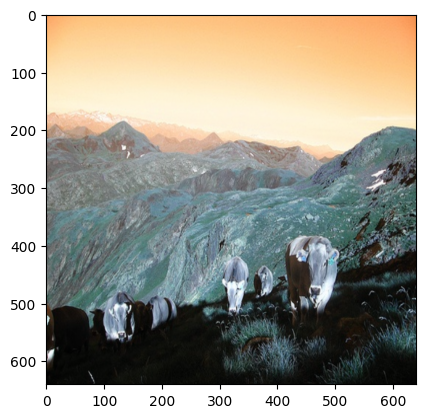

In [22]:
# show image
plt.figure()
#convert bgr to rgb
plt.imshow(sample['image'][0])
plt.show()

# OpenPifPaf

In [25]:
!python3 -m openpifpaf.predict images/tappo_loomo.jpg --image-output --checkpoint=shufflenetv2k30-animalpose --line-width=6 --font-size=6 --white-overlay=0.3 --long-edge=500

C:\Users\osour\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe: Error while finding module specification for 'openpifpaf.predict' (ModuleNotFoundError: No module named 'openpifpaf')
